# Iceshelves mask for bed machine Antarctica 1

For OM4p125 runs that will not resolve the iceshelves, we need to build a mask that will mask out the cavities in the resulting land sea mask. This notebook will regrid the bedmachine mask onto the OM4p125 grid.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import xesmf
import subprocess as sp

In [2]:
#%matplotlib qt
%matplotlib inline

In [3]:
_ = xr.set_options(display_style='text')

## Import model grid

In [4]:
hgrid = '/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing.2/ocean_hgrid.nc'

In [5]:
!cp /work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing.2/ocean_hgrid.nc .

In [6]:
# verif hgrid
bytesout = sp.check_output(f'md5sum ocean_hgrid.nc', shell=True)
md5 = bytesout.decode('utf8').split()[0]
assert md5 == '14b5aaef784a1b6aca87ab92498ef262'

## Adding lon/lat from the CRS

Coordinates is given in meters in a polar stereographic coordinate reference system. We need to create the corresponding longitude/latitude arrays using the PROJ library.

bedmachine coordinates are carthesian (in $m$, centered on the south pole) in a polar stereographic projection. To get the corresponding longitude/latitude, we use the inverse transformation from the CRS:

The PROJ string is available here: 
    
https://nsidc.org/data/NSIDC-0756/versions/1

In [7]:
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

Write a function to compute the longitude and latitude using the inverse transformation from the CRS:

In [8]:
def add_lon_lat(ds, PROJSTRING, x='x', y='y', chunks={}):
    """ add longitude and latitude as compute from the inverse projection
    given in PROJSTRING
    
    PARAMETERS:
    -----------
    ds: xarray.Dataset
    
    PROJSTRING: str
    
    """
    from pyproj import CRS, Transformer
    # create the coordinate reference system
    crs = CRS.from_proj4(PROJSTRING)
    # create the projection from lon/lat to x/y
    proj = Transformer.from_crs(crs.geodetic_crs, crs)
    # make x,y 2d arrays
    xx, yy = np.meshgrid(ds[x].values, ds[y].values)
    # compute the lon/lat
    lon, lat = proj.transform(xx, yy, direction='INVERSE')
    # add to dataset
    ds['lon'] = xr.DataArray(data=lon, dims=('y', 'x'))
    ds['lat'] = xr.DataArray(data=lat, dims=('y', 'x'))
    ds['lon'].attrs = dict(units='degrees_east')
    ds['lat'].attrs = dict(units='degrees_north')
    return ds

Fist time computing lon/lat takes about 2 minutes. Write the results into a new file. Next time, we can just load the file:

In [9]:
compute_geo=False

In [10]:
%%time

bmdir = '/archive/Raphael.Dussin/datasets/topography/BedMachineAntarctica_v1'

if compute_geo:
    bedmachine = xr.open_dataset(f'{bmdir}/BedMachineAntarctica_2019-11-05_v01.nc')
    # this should take a couple of minutes
    bedmachine = add_lon_lat(bedmachine, PROJSTRING)
    bedmachine = bedmachine.assign_coords({'lon': bedmachine.lon,
                                           'lat': bedmachine.lat})
    bedmachine.to_netcdf('bedmachine+geo.nc', format='NETCDF3_64BIT')
else:
    bedmachine = xr.open_dataset(f'{bmdir}/bedmachine+geo.nc')

CPU times: user 11 ms, sys: 9 ms, total: 20 ms
Wall time: 29.6 ms


In [11]:
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
    lon        (y, x) float64 ...
    lat        (y, x) float64 ...
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes:
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     05-Nov-2019 (v1.38)
    nx:                          13333.0
    ny:                          13333.0
    Projection:                  Polar Stereographic South (71S,0E)
    proj4:                       +init=epsg:3031
    sea_water_density (kg m-3):  1027.0
    ice_density (kg m-3):        917.0
    xmin:                        -3333000
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

Text(0.5, 1.0, 'Bedmachine mask')

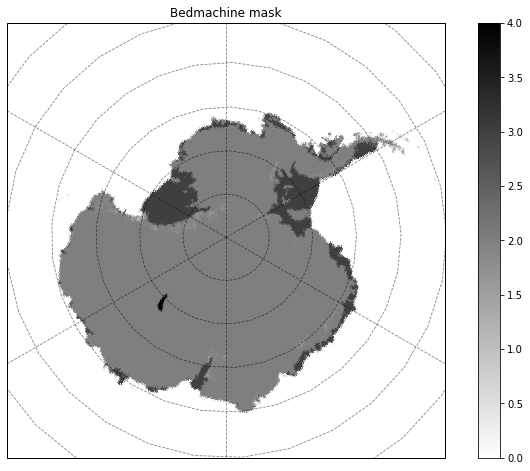

In [12]:
# round up for coarsening
start=0
end=13000

bedtmp = bedmachine.isel(x=slice(start,end),
                         y=slice(start,end))
                         

bedmachine_mask_subsample = bedtmp.mask.coarsen(x=50, y=50).mean()


bedmachine_mask_subsample['lon'] = xr.DataArray(bedtmp['lon'].values[::50,::50],
                                                dims=('y', 'x'))
bedmachine_mask_subsample['lat'] = xr.DataArray(bedtmp['lat'].values[::50,::50],
                                                dims=('y', 'x'))

subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = bedmachine_mask_subsample.plot(x='lon', y='lat',
                                   vmin=0, vmax=4,
                                   cmap='binary',
                                   subplot_kws=subplot_kws,
                                   transform=ccrs.PlateCarree(),
                                   add_labels=False,
                                   add_colorbar=True)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -60, -90], ccrs.PlateCarree())
p.axes.set_title('Bedmachine mask')

From documentation: **The ice/land masks are from ADD rock outcrop, and the floating ice is derived from InSAR grounding lines (pers. comm.). 0 = ocean, 1 = ice-free land, 2 = grounded ice, 3 = floating ice, 4 = lake Vostok**

Which means we can take all values >=1 to be our land + ice-shelves mask:

In [13]:
bedmachine['icemask'] = bedmachine['mask'].clip(min=0, max=1)

Text(0.5, 1.0, 'Bedmachine iceshelves mask')

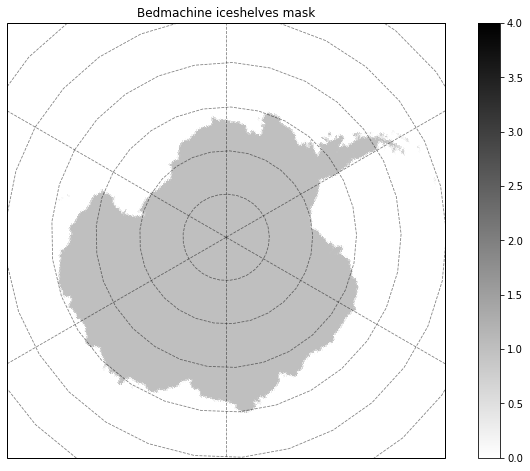

In [14]:
# round up for coarsening
start=0
end=13000

bedtmp = bedmachine.isel(x=slice(start,end),
                         y=slice(start,end))
                         

bedmachine_mask_subsample = bedtmp.icemask.coarsen(x=50, y=50).mean()


bedmachine_mask_subsample['lon'] = xr.DataArray(bedtmp['lon'].values[::50,::50],
                                                dims=('y', 'x'))
bedmachine_mask_subsample['lat'] = xr.DataArray(bedtmp['lat'].values[::50,::50],
                                                dims=('y', 'x'))

subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = bedmachine_mask_subsample.plot(x='lon', y='lat',
                                   vmin=0, vmax=4,
                                   cmap='binary',
                                   subplot_kws=subplot_kws,
                                   transform=ccrs.PlateCarree(),
                                   add_labels=False,
                                   add_colorbar=True)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -60, -90], ccrs.PlateCarree())
p.axes.set_title('Bedmachine iceshelves mask')

## Remapping onto OM4p125 grid:

In [15]:
OM4p125_super = xr.open_dataset(hgrid)

In [16]:
OM4p125 = xr.Dataset()
lon = OM4p125_super['x'].values[1::2,1::2].copy()
lat = OM4p125_super['y'].values[1::2,1::2].copy()
OM4p125['lon'] = xr.DataArray(data=lon, dims=('yh', 'xh'), attrs={'units': 'degrees_east'})
OM4p125['lat'] = xr.DataArray(data=lat, dims=('yh', 'xh'), attrs={'units': 'degrees_north'})

Restrict to latitudes south of 60S (roughly) to speed-up regridding:

In [17]:
OM4p125_SO = OM4p125.isel(yh=slice(0,500))

In [18]:
OM4p125_SO.to_netcdf('OM4p125_SO.nc', format='NETCDF3_64BIT')

Run the regridding on gaea with:

**salloc -N 7 --cluster=c4 -qos=urgent**

**conda activate repro**

**mpirun -np 252 ESMF_RegridWeightGen -s bedmachine+geo.nc -d OM4p125_SO.nc -w wgts_nn_bedmachine_OM4p125.nc -m neareststod --netcdf4 --src_regional**

Sanity checks on checksums:

In [19]:
weightsdir = '/archive/Raphael.Dussin/datasets/OM4p125/regrid_weights_bedmachine_ant1'

In [20]:
# verif weights
bytesout = sp.check_output(f'md5sum {weightsdir}/wgts_nn_bedmachine_OM4p125.nc', shell=True)
md5 = bytesout.decode('utf8').split()[0]
assert md5 == '0e19a7eb7b8a498e55d24db8fec4879d'

In [21]:
# verif target grid
bytesout = sp.check_output(f'md5sum OM4p125_SO.nc', shell=True)
md5 = bytesout.decode('utf8').split()[0]
assert md5 == 'e28fe0f3ff52a35129182ce73e507060'

In [22]:
%%time

regrid = xesmf.Regridder(bedmachine, OM4p125_SO,
                         method='nearest_s2d',
                         periodic=False,
                         reuse_weights=True,
                         filename=f'{weightsdir}/wgts_nn_bedmachine_OM4p125.nc')

Reuse existing file: /archive/Raphael.Dussin/datasets/OM4p125/regrid_weights_bedmachine_ant1/wgts_nn_bedmachine_OM4p125.nc
CPU times: user 2.74 s, sys: 4.7 s, total: 7.44 s
Wall time: 7.82 s


Now we can regrid the ice-shelves mask:

In [23]:
icemask_SO = regrid(bedmachine['icemask'])
icemask_SO['lon'] = OM4p125_SO['lon']
icemask_SO['lat'] = OM4p125_SO['lat']

In [24]:
icemask_SO

<xarray.DataArray 'icemask' (yh: 500, xh: 2880)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lon      (yh, xh) float64 -298.6 -298.5 -298.4 -298.2 ... 59.69 59.81 59.94
    lat      (yh, xh) float64 -82.46 -82.46 -82.45 ... -59.39 -59.39 -59.39
Dimensions without coordinates: yh, xh
Attributes:
    regrid_method:  nearest_s2d

and concatenate with zeros in the north:

In [25]:
icemask_zeros = xr.zeros_like(OM4p125['lon'].isel(yh=slice(500,2241)))
icemask_zeros['lon'] = OM4p125['lon'].isel(yh=slice(500,2241))
icemask_zeros['lat'] = OM4p125['lat'].isel(yh=slice(500,2241))

icemask = xr.concat([icemask_SO, icemask_zeros], dim='yh')

# revert land and ocean
icemask = 1 - icemask

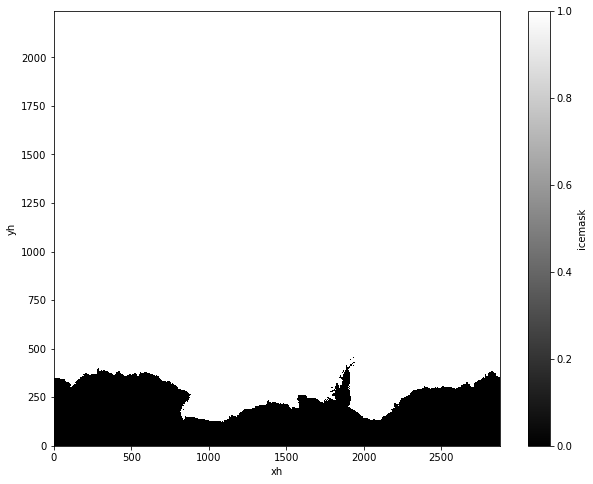

In [26]:
plt.figure(figsize=[10,8])
icemask.plot(cmap='binary_r')

## Apply ice9

In [27]:
def ice9it(i,j,mask):
  # Iterative implementation of "ice 9"
  wetMask = 0*mask
  (nj, ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
    if wetMask[j,i] or mask[j,i] <= 0: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask

In [28]:
tmp = ice9it(1000, 1000, icemask.values)
icemask_ice9 = xr.DataArray(tmp, dims=icemask.dims)

In [29]:
iceshelves_mask = xr.Dataset()
iceshelves_mask['lon'] = OM4p125['lon']
iceshelves_mask['lat'] = OM4p125['lat']
iceshelves_mask['mask'] = xr.DataArray(data=icemask_ice9.values, dims=('yh', 'xh'))
iceshelves_mask['mask'].attrs = {'long_name': 'mask for antarctic ice shelves',
                                 'units': 'non-dimensional',
                                 'coordinates': 'lon lat'}

encoding = {'mask': {'dtype': np.int16, '_FillValue': 32767},
            'lon': {'_FillValue': 1.0e+20},
            'lat': {'_FillValue': 1.0e+20}}
iceshelves_mask.to_netcdf('BedMachineAntarctic_iceshelves_mask_OM4p125.nc',
                          encoding=encoding, format='NETCDF3_64BIT')

In [30]:
# verif output mask
bytesout = sp.check_output(f'md5sum BedMachineAntarctic_iceshelves_mask_OM4p125.nc', shell=True)
md5 = bytesout.decode('utf8').split()[0]
assert md5 == 'd0ae312d5ac7a6267bc072a54438e68e'

## Create an ocean_topog without iceshelves

In [31]:
topo_iceshelves = xr.open_dataset('ocean_topog.nc')

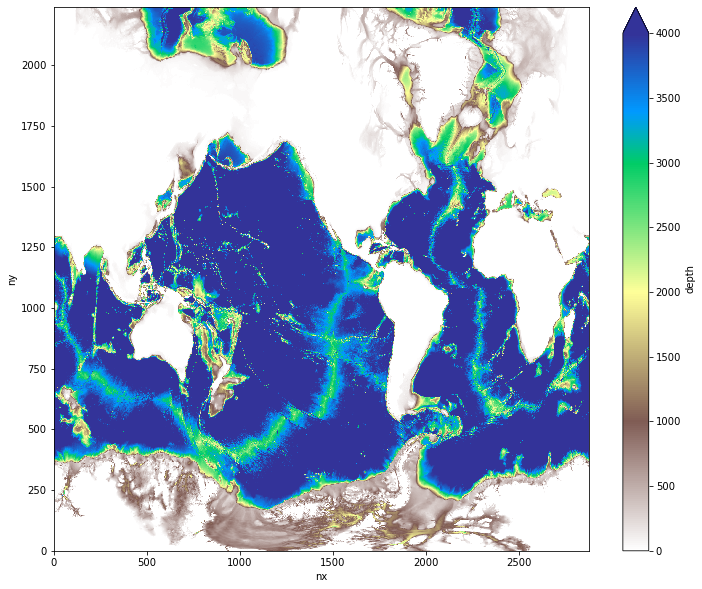

In [32]:
plt.figure(figsize=[12,10])
topo_iceshelves['depth'].plot(vmin=0, vmax=4000, cmap='terrain_r')

In [33]:
topo_noiceshelves = topo_iceshelves.copy(deep=True)

In [34]:
depth_updated = topo_noiceshelves['depth'].values * icemask_ice9.values
topo_noiceshelves['depth'] = xr.DataArray(depth_updated,
                                          coords=topo_iceshelves['depth'].coords,
                                          dims=topo_iceshelves['depth'].dims,
                                          attrs=topo_iceshelves['depth'].attrs)

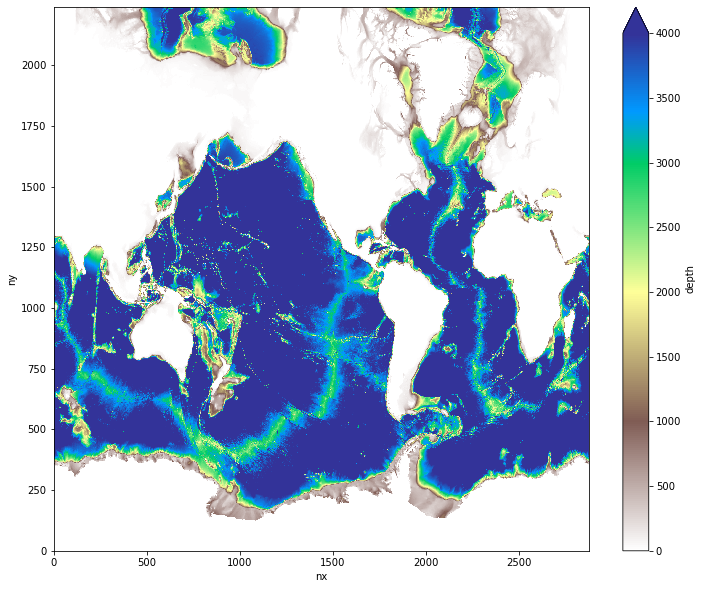

In [35]:
plt.figure(figsize=[12,10])
topo_noiceshelves['depth'].plot(vmin=0, vmax=4000, cmap='terrain_r')

In [36]:
# set up encoding and attributes
encoding = {'depth': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'height': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h2': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_std': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_min': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_max': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'x': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'y': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'tile': {'_FillValue': 1.0e+20, 'dtype': np.float64},
           }

# need to remove coordinates to set them in a reproducible order
# which means rewritting the dataset from scratch
out = xr.Dataset()
for var in ['depth', 'height', 'h2', 'h_std', 'h_min', 'h_max', 'x', 'y', 'tile']:
    out[var] = xr.DataArray(topo_noiceshelves[var].values,
                            dims=topo_noiceshelves[var].dims,
                            attrs=topo_noiceshelves[var].attrs)


out['x'].attrs = {'units': 'degrees_east'}
out['y'].attrs = {'units': 'degrees_north'}
out['depth'].attrs.update(dict(coordinates="x y"))
out['height'].attrs.update(dict(coordinates="x y"))
out['h2'].attrs.update(dict(coordinates="x y"))
out['h_std'].attrs.update(dict(coordinates="x y"))
out['h_min'].attrs.update(dict(coordinates="x y"))
out['h_max'].attrs.update(dict(coordinates="x y"))

# update the history
out.attrs = topo_noiceshelves.attrs.copy()
out.attrs['history'] += '; masking the antarctic ice-shelves'

out.to_netcdf('ocean_topog_noiceshelves.nc', encoding=encoding,
              format='NETCDF3_64BIT', engine='netcdf4')

In [37]:
# verif output mask
bytesout = sp.check_output(f'md5sum ocean_topog_noiceshelves.nc', shell=True)
md5 = bytesout.decode('utf8').split()[0]
assert md5 == 'f469ffec0d64f271674c044bf2594c90'